Import

In [255]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import ttest_ind, levene
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from autofeatselect import FeatureSelector
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import optuna

# Data

In [256]:
original_data = pd.read_csv("./data/horse.csv")
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

### Exploratory Data Analysis (EDA)

    1. Explore distributions of numerical features.
    2. Explore distributions of categorical features.
    3. Explore relationships between features and the target variable.

### Statistical Analysis

    1. Perform hypothesis tests to understand significance.
    2. Analyze variance to understand feature importance.

### Feature Engineering Suggestions

    1. Based on EDA and Statistical Analysis, suggest potential new features or transformations.

In [257]:
# Identify categorical features in the datasets
categorical_features_train = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_features_horse = original_data.select_dtypes(include=['object']).columns.tolist()
categorical_features_test = test_data.select_dtypes(include=['object']).columns.tolist()
categorical_features_train.remove('outcome')
categorical_features_horse.remove('outcome')
categorical_features = categorical_features_train

def calculate_category_frequencies(data, categorical_features):
    category_frequencies = {}
    for feature in categorical_features:
        frequencies = data[feature].value_counts(normalize=True).to_dict()
        category_frequencies[feature] = frequencies
    return category_frequencies

# Calculate category frequencies for each categorical feature in train_data, horse_data, and test_data
train_category_frequencies = calculate_category_frequencies(train_data, categorical_features)
horse_category_frequencies = calculate_category_frequencies(original_data, categorical_features)
test_category_frequencies = calculate_category_frequencies(test_data, categorical_features)

# Compare the category frequencies across the datasets and identify discrepancies or rare categories
rare_categories = {
    "Feature": [],
    "Category": [],
    "Train Proportion": [],
    "Horse Proportion": [],
    "Test Proportion": []
}
for feature in categorical_features:
    train_categories = set(train_category_frequencies.get(feature, {}).keys())
    horse_categories = set(horse_category_frequencies.get(feature, {}).keys())
    test_categories = set(test_category_frequencies.get(feature, {}).keys())
    
    # Get the union of all categories present in any of the datasets for the given feature
    all_categories = train_categories.union(horse_categories).union(test_categories)
    
    for category in all_categories:
        # Append the category and its proportion in each dataset to the dictionary
        rare_categories["Feature"].append(feature)
        rare_categories["Category"].append(category)
        rare_categories["Train Proportion"].append(train_category_frequencies.get(feature, {}).get(category, 0))
        rare_categories["Horse Proportion"].append(horse_category_frequencies.get(feature, {}).get(category, 0))
        rare_categories["Test Proportion"].append(test_category_frequencies.get(feature, {}).get(category, 0))

# Convert the results to a DataFrame and display
rare_categories_df = pd.DataFrame(rare_categories)
rare_categories_df

Feature Category  Train Proportion  Horse Proportion  \
0               surgery      yes              0.72              0.60   
1               surgery       no              0.28              0.40   
2                   age    young              0.06              0.08   
3                   age    adult              0.94              0.92   
4   temp_of_extremities     warm              0.04              0.12   
..                  ...      ...               ...               ...   
56    abdomo_appearance    clear              0.22              0.31   
57      surgical_lesion      yes              0.75              0.64   
58      surgical_lesion       no              0.25              0.36   
59              cp_data      yes              0.54              0.33   
60              cp_data       no              0.46              0.67   

    Test Proportion  
0              0.71  
1              0.29  
2              0.05  
3              0.95  
4              0.04  
..              ...  
56             0.22  
57             0.75  
58             0.25  
59             0.53  
60             0.47  

[61 rows x 5 columns]

In [258]:
discrete_features = []
continuous_features = []

# Classify numerical features as discrete or continuous
for col in train_data.select_dtypes(include=['int64', 'float64']).columns:
    if col == 'id':  # 'id' is not a feature
        continue
    
    # Consider integer type features with less than 15 unique values as discrete
    if train_data[col].dtype == 'int64' and len(train_data[col].unique()) < 15:
        discrete_features.append(col)
    # Consider float type features and integer type features with 15 or more unique values as continuous
    else:
        continuous_features.append(col)

# Display the classified features
print(f"categorical_features: \n{categorical_features}\ndiscrete_features: \n{discrete_features}\ncontinuous_features: \n{continuous_features}")

categorical_features: 
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']
discrete_features: 
['lesion_2', 'lesion_3']
continuous_features: 
['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1']


In [259]:
# Correct the classification of features
discrete_features.append('lesion_1')
continuous_features.remove('lesion_1')

categorical_features.append('hospital_number')
continuous_features.remove('hospital_number')

# Display the classified features
print(f"categorical_features: \n{categorical_features}\ndiscrete_features: \n{discrete_features}\ncontinuous_features: \n{continuous_features}")

categorical_features: 
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'hospital_number']
discrete_features: 
['lesion_2', 'lesion_3', 'lesion_1']
continuous_features: 
['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein']


In [260]:
for c in categorical_features:
    print(f"{c} : {train_data[c].nunique()}")

surgery : 2
age : 2
temp_of_extremities : 4
peripheral_pulse : 4
mucous_membrane : 6
capillary_refill_time : 3
pain : 6
peristalsis : 5
abdominal_distention : 4
nasogastric_tube : 3
nasogastric_reflux : 4
rectal_exam_feces : 5
abdomen : 5
abdomo_appearance : 3
surgical_lesion : 2
cp_data : 2
hospital_number : 255


removing hospital_number from count plot due to high unique values

In [261]:
rev_categorical_features = categorical_features[:-1]

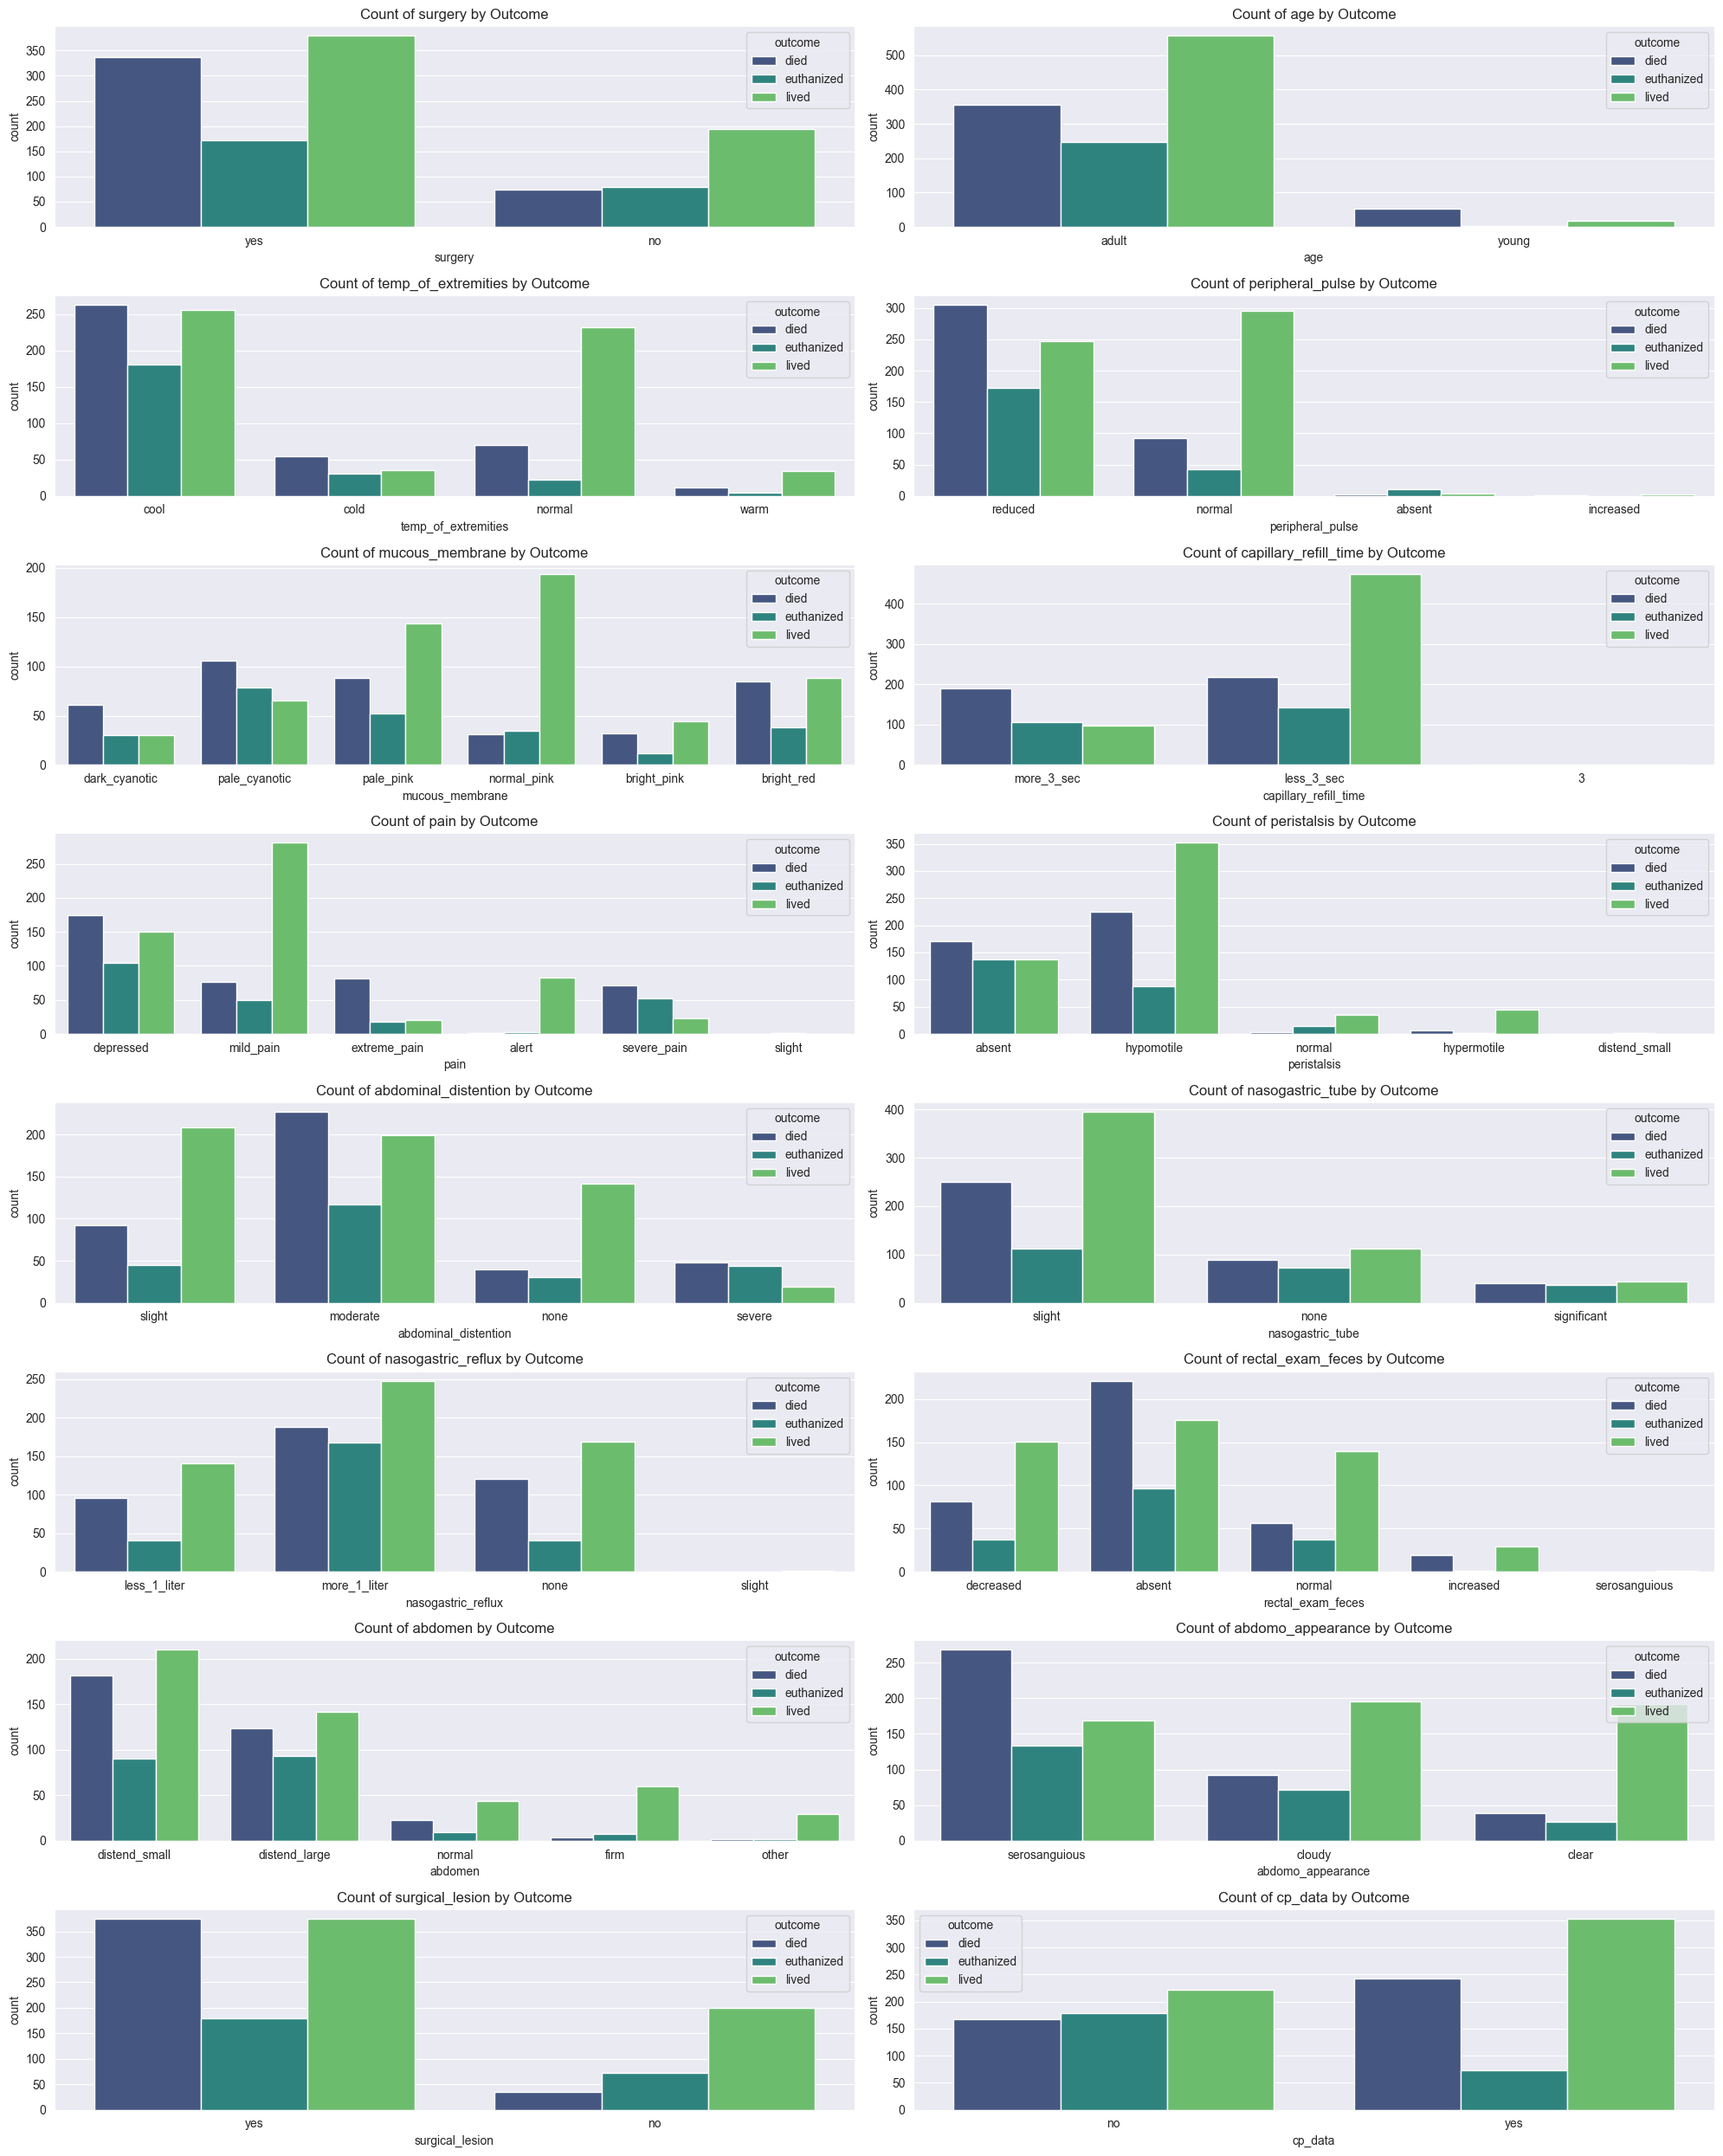

In [262]:
plt.figure(figsize=(20, 25))
num_categorical_features = len(rev_categorical_features)

# Iterate over categorical features and plot the countplot for each feature colored by the target variable 'outcome'
for i, col in enumerate(rev_categorical_features, 1):
    plt.subplot((num_categorical_features + 1) // 2, 2, i)
    sns.countplot(data=train_data, x=col, hue='outcome', palette='viridis')
    plt.title(f'Count of {col} by Outcome')
    #plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

The count plots above depict the distribution of each categorical feature, differentiated by the levels of the target variable outcome.

### Chi-Square Test of Independence

For each categorical feature, we can set up the null hypothesis ( ***H<sub>0</sub>***) and the alternative hypothesis (***H<sub>1</sub>***) as follows:

* Null Hypothesis (***H<sub>0</sub>***): There is no association between the categorical feature and the target variable outcome.
* Alternative Hypothesis (***H<sub>1</sub>***): There is a significant association between the categorical feature and the target variable outcome.

If the p-value is less than the significance level (usually 0.05), we reject the null hypothesis, indicating that there is a significant association between the categorical feature and the target variable.

In [263]:
# Initialize a dictionary to store the p-values from the Chi-Square tests
chi2_p_values = {}

# Perform Chi-Square Test of Independence for each categorical feature against the target variable 'outcome'
for col in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(train_data[col], train_data['outcome'])
    
    # Perform the Chi-Square test
    _, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Store the p-value in the dictionary
    chi2_p_values[col] = p_value

# Convert the dictionary to a sorted DataFrame for better readability
chi2_results_df = pd.DataFrame(list(chi2_p_values.items()), columns=['Feature', 'P-Value'])
chi2_results_df = chi2_results_df.sort_values(by='P-Value').reset_index(drop=True)
chi2_results_df

Feature  P-Value
0                    pain     0.00
1       abdomo_appearance     0.00
2        peripheral_pulse     0.00
3         mucous_membrane     0.00
4         hospital_number     0.00
5     temp_of_extremities     0.00
6    abdominal_distention     0.00
7             peristalsis     0.00
8   capillary_refill_time     0.00
9         surgical_lesion     0.00
10                cp_data     0.00
11                abdomen     0.00
12                    age     0.00
13      rectal_exam_feces     0.00
14                surgery     0.00
15     nasogastric_reflux     0.00
16       nasogastric_tube     0.00

The Chi-Square tests of independence have been performed, and the p-values are listed above for each categorical feature. The smaller the p-value, the stronger the evidence to reject the null hypothesis, indicating a significant association between the feature and the target variable outcome

**Observations:**
* Features like pain, abdomo_appearance, peripheral_pulse, and abdominal_distention have extremely low p-values, indicating a very strong association with the target variable outcome.
* All the categorical features have a p-value less than 0.05, suggesting that they all have some level of association with the target variable.

In [264]:
# Remove 'hospital_number' from the list of categorical features for one-hot encoding
if 'hospital_number' in categorical_features:
    categorical_features_train.remove('hospital_number')
if 'hospital_number' in categorical_features:
    categorical_features_test.remove('hospital_number')

# Apply one-hot encoding to the categorical features, except for 'hospital_number'
train_data = pd.get_dummies(train_data, columns=categorical_features_train, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_features_test, drop_first=True)

# Convert boolean columns to int
bool_cols_train = train_data.select_dtypes(include=['bool']).columns.tolist()
bool_cols_test = test_data.select_dtypes(include=['bool']).columns.tolist()

train_data[bool_cols_train] = train_data[bool_cols_train].astype(int)
test_data[bool_cols_test] = test_data[bool_cols_test].astype(int)


# Handle additional/missing columns between the train and test datasets after one-hot encoding
missing_cols = set(train_data.columns) - set(test_data.columns)
for c in missing_cols:
    test_data[c] = 0
test_data_encoded = test_data[train_data.columns]

def handle_unseen_labels(train_series, test_series):
    """
    Label encodes the 'train_series'. Assigns the same label to the values in 'test_series' which are 
    also present in 'train_series'. Assigns a new label to the values in 'test_series' which are not 
    present in 'train_series'.
    """
    label_encoder = LabelEncoder()
    label_encoder.fit(train_series)
    
    train_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    test_mapping = {val: train_mapping.get(val, len(train_mapping)) for val in test_series.unique()}
    
    train_series_transformed = train_series.map(train_mapping)
    test_series_transformed = test_series.map(test_mapping)
    
    return train_series_transformed, test_series_transformed

# Apply label encoding to 'hospital_number'
train_data['hospital_number'], test_data['hospital_number'] = handle_unseen_labels(
    train_data['hospital_number'], 
    test_data['hospital_number']
)
train_data.head()

id  hospital_number  rectal_temp  pulse  respiratory_rate  \
0   0              109        38.10 132.00             24.00   
1   1              153        37.50  88.00             12.00   
2   2              101        38.30 120.00             28.00   
3   3              226        37.10  72.00             30.00   
4   4              252        38.00  52.00             48.00   

   nasogastric_reflux_ph  packed_cell_volume  total_protein  abdomo_protein  \
0                   6.50               57.00           8.50            3.40   
1                   2.00               33.00          64.00            2.00   
2                   3.50               37.00           6.40            3.40   
3                   2.00               53.00           7.00            3.90   
4                   7.00               47.00           7.30            2.60   

   lesion_1  ...  rectal_exam_feces_normal  rectal_exam_feces_serosanguious  \
0      2209  ...                         0                                0   
1      2208  ...                         0                                0   
2      5124  ...                         0                                0   
3      2208  ...                         0                                0   
4         0  ...                         1                                0   

  abdomen_distend_small  abdomen_firm  abdomen_normal  abdomen_other  \
0                     1             0               0              0   
1                     1             0               0              0   
2                     0             0               0              0   
3                     1             0               0              0   
4                     0             0               1              0   

   abdomo_appearance_cloudy  abdomo_appearance_serosanguious  \
0                         0                                1   
1                         0                                1   
2                         0                                1   
3                         1                                0   
4                         1                                0   

   surgical_lesion_yes  cp_data_yes  
0                    1            0  
1                    1            0  
2                    1            0  
3                    1            1  
4                    0            1  

[5 rows x 57 columns]

## Discrete Features

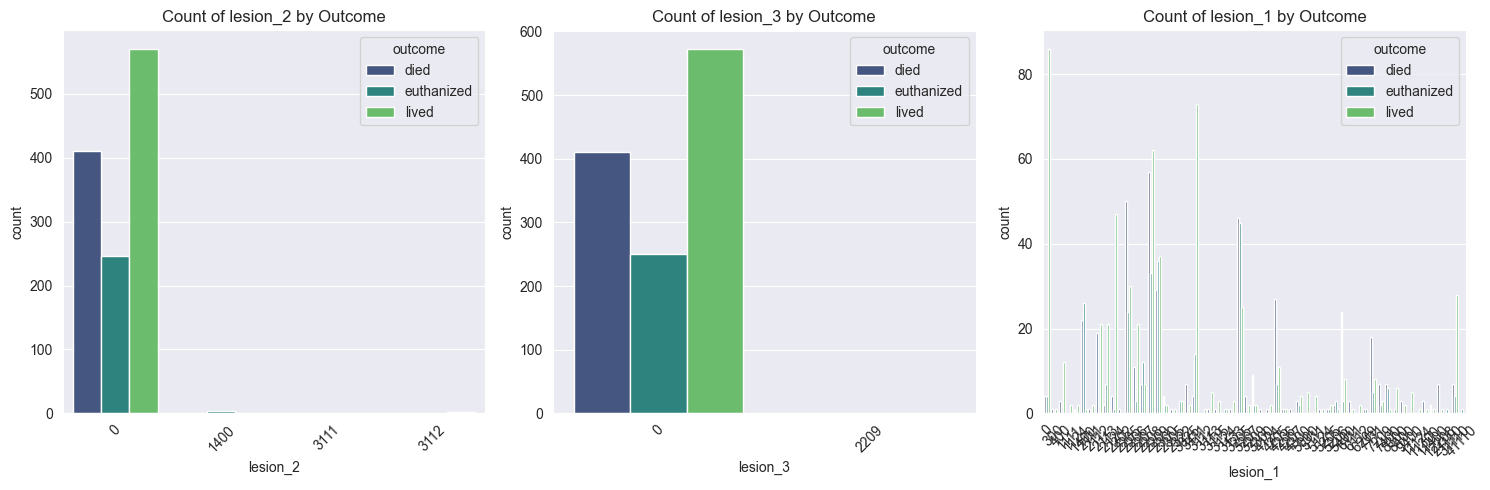

In [265]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 5))
num_discrete_features = len(discrete_features)

# Iterate over discrete features and plot the countplot for each feature colored by the target variable 'outcome'
for i, col in enumerate(discrete_features, 1):
    plt.subplot(1, num_discrete_features, i)
    sns.countplot(data=train_data, x=col, hue='outcome', palette='viridis')
    plt.title(f'Count of {col} by Outcome')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


In [266]:
site_mapping = {
    '1': 'gastric', '2': 'sm intestine', '3': 'lg colon', '4': 'lg colon and cecum', 
    '5': 'cecum', '6': 'transverse colon', '7': 'retum/descending colon', 
    '8': 'uterus', '9': 'bladder', '11': 'all intestinal sites','0': 'none'
}
type_mapping = {
    '1': 'simple', '2': 'strangulation', '3': 'inflammation', '4': 'other', '0': 'none'
}
subtype_mapping = {
    '1': 'mechanical', '2': 'paralytic', '0': 'none','3':'n/a'
}
specific_code_mapping = {
    '1': 'obturation', '2': 'intrinsic', '3': 'extrinsic', '4': 'adynamic', '5': 'volvulus/torsion',
    '6': 'intussuption', '7': 'thromboembolic', '8': 'hernia', '9': 'lipoma/slenic incarceration',
    '10': 'displacement', '0': 'none',
    '01': 'obturation', '02': 'intrinsic', '03': 'extrinsic', '04': 'adynamic', '05': 'volvulus/torsion',
    '06': 'intussuption', '07': 'thromboembolic', '08': 'hernia', '09': 'lipoma/slenic incarceration',
    '10': 'displacement', '00': 'none'
}

In [267]:
def explode_lesion(x):
    code = str(x)
    result = []
    if code == '0':
        result = ['0','0','0','0']
    elif len(code) == 2:
        result = [code[0],'0','0',code[1]]
    if len(code) == 3:
        result = [code[0], code[1], code[2], '0']

    elif len(code) == 4:
        result = [code[0], code[1], code[2], code[3]]

    elif len(code) == 5:
        if code[0:2] == '11':
            result = [code[0:2], code[2], code[3], code[4]]
        else:
            result = [code[0], code[1], code[2], code[3:]]
            
    result[0] = site_mapping[result[0]]
    result[1] = type_mapping[result[1]]
    result[2] = subtype_mapping[result[2]]
    result[3] = specific_code_mapping[result[3]]
    return result

In [268]:
train_data[['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']] = train_data.lesion_1.apply(explode_lesion).apply(pd.Series)
test_data[['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']] = test_data.lesion_1.apply(explode_lesion).apply(pd.Series)

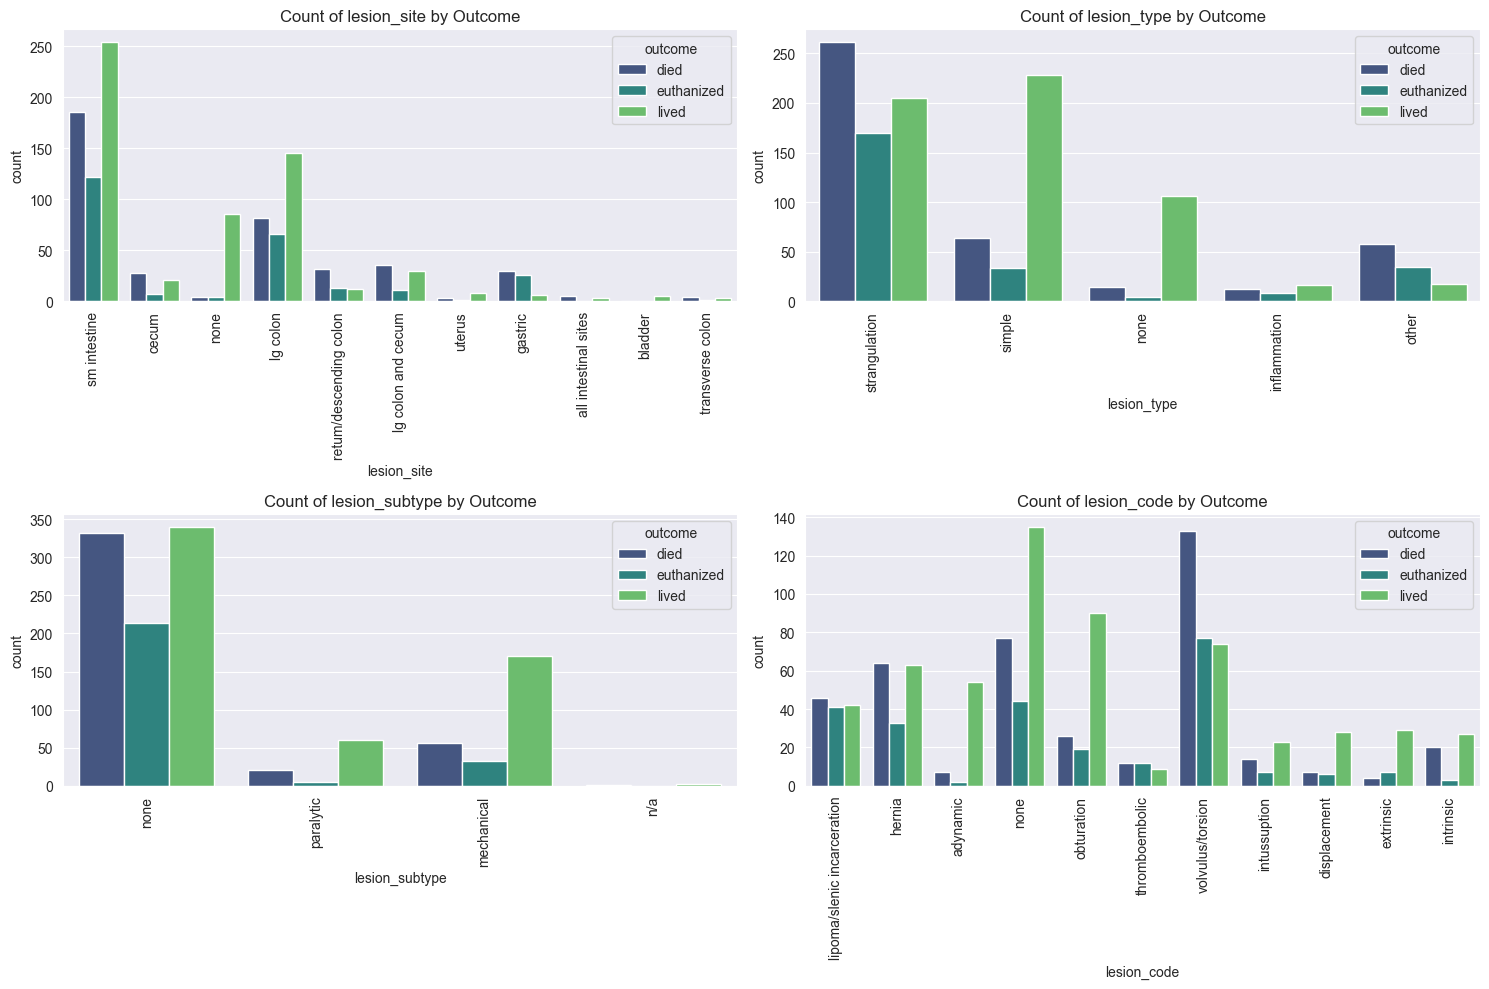

In [269]:
decomposed_features = [f'lesion_{component}' 
                       for component in ['site', 'type', 'subtype', 'code']]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
num_decomposed_features = len(decomposed_features)

# Iterate over decomposed features and plot the countplot for each feature colored by the target variable 'outcome'
for i, col in enumerate(decomposed_features, 1):
    plt.subplot((num_decomposed_features + 1) // 2, 2, i)
    sns.countplot(data=train_data, x=col, hue='outcome', palette='viridis')
    plt.title(f'Count of {col} by Outcome')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()


Frequency Encoding

In [270]:
"""for col in ['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']:
    freq_enc = train_data.groupby(col).size() / len(train_data)
    train_data[f'{col}_freq'] = train_data[col].map(freq_enc)
    test_data[f'{col}_freq'] = test_data[col].map(freq_enc)  # handle unseen categories in test data
"""

"for col in ['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']:\n    freq_enc = train_data.groupby(col).size() / len(train_data)\n    train_data[f'{col}_freq'] = train_data[col].map(freq_enc)\n    test_data[f'{col}_freq'] = test_data[col].map(freq_enc)  # handle unseen categories in test data\n"

In [271]:
train_data = pd.get_dummies(train_data, columns=['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code'], drop_first=True)

# Convert boolean columns to int
bool_cols_train = train_data.select_dtypes(include=['bool']).columns.tolist()
bool_cols_test = test_data.select_dtypes(include=['bool']).columns.tolist()

train_data[bool_cols_train] = train_data[bool_cols_train].astype(int)
test_data[bool_cols_test] = test_data[bool_cols_test].astype(int)

## Continous Features

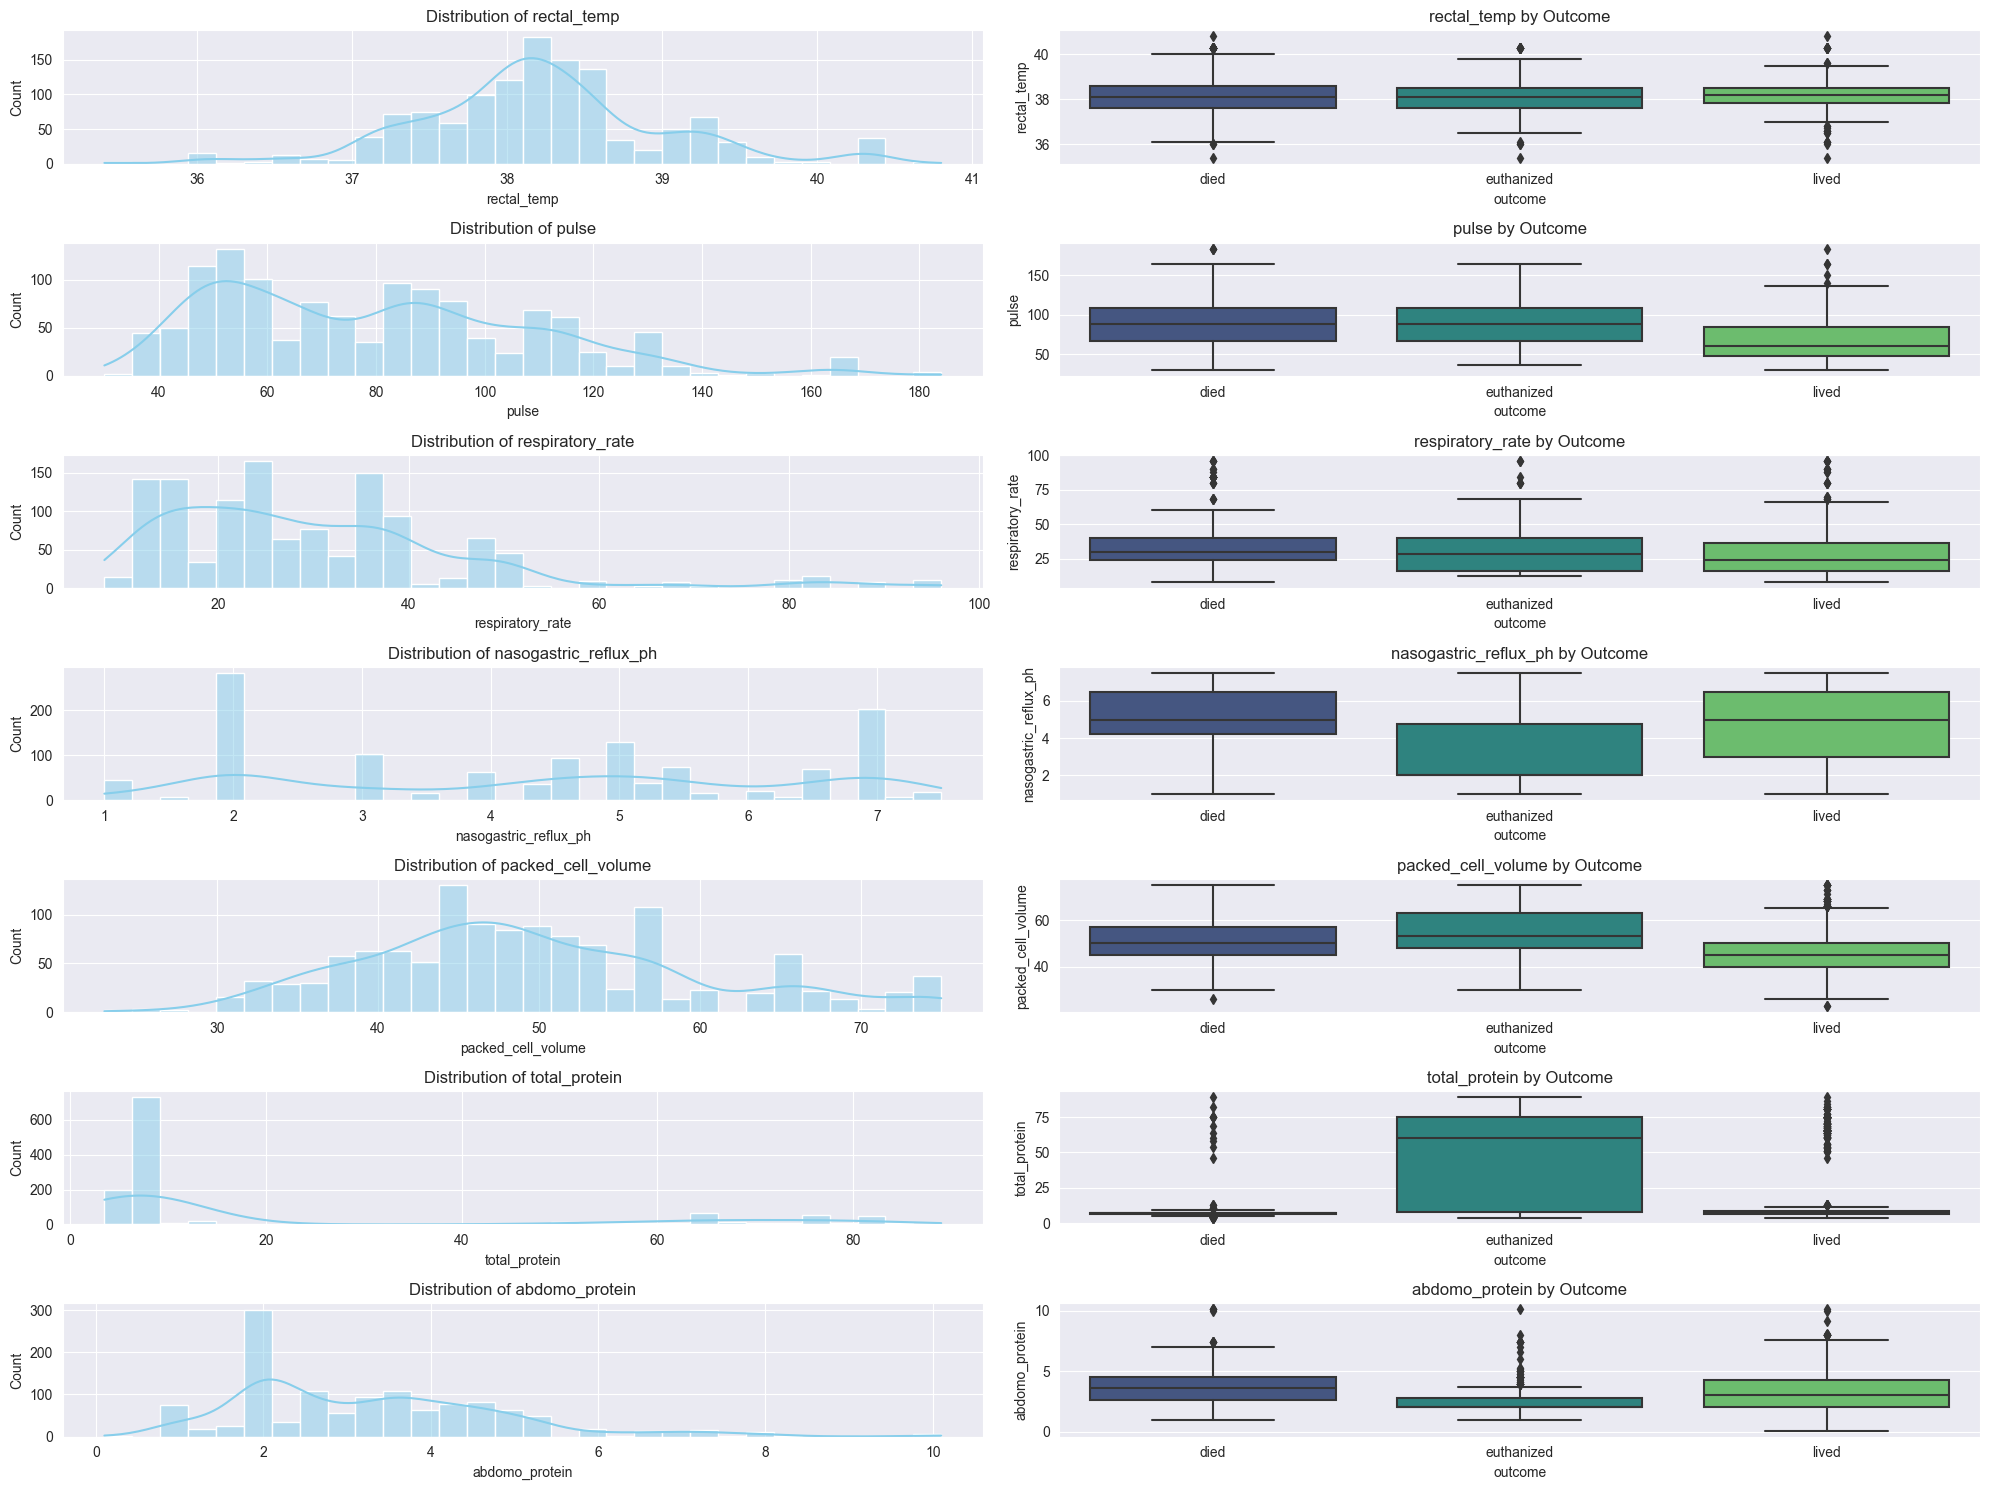

In [272]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))
num_continuous_features = len(continuous_features)

# Iterate over continuous features and plot the histogram and boxplot for each feature against the target variable 'outcome'
for i, col in enumerate(continuous_features, 1):
    plt.subplot(num_continuous_features, 2, 2 * i - 1)
    sns.histplot(train_data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    
    plt.subplot(num_continuous_features, 2, 2 * i)
    sns.boxplot(x='outcome', y=col, data=train_data, palette='viridis')
    plt.title(f'{col} by Outcome')

plt.tight_layout()
plt.show()


**Observations:**
* Rectal Temperature (rectal_temp):

    - Appears to be normally distributed with a slight left skew.
    - Presence of outliers in each class, but more pronounced in the 'died' and 'euthanized' classes.

* Pulse (pulse):

    - Right-skewed distribution.
    - Variability in distributions among different outcomes, with 'died' and 'euthanized' classes having higher medians.
    - Presence of outliers in each class, especially in the 'lived' class.

* Respiratory Rate (respiratory_rate):

    - Highly right-skewed.
    - 'Died' class has higher medians and more pronounced outliers.

* Nasogastric Reflux PH (nasogastric_reflux_ph):

    - Seems to have a multimodal distribution.
    - Distributions vary across different outcomes.
    - Outliers are present in each class.

* Packed Cell Volume (packed_cell_volume):

    - Approximately normally distributed with slight right skewness.
    - Outliers are present, especially in the 'lived' class.

* Total Protein (total_protein):

    - Highly right-skewed.
    - Multiple outliers in each class, with 'euthanized' class having pronounced higher values.

* Abdomo Protein (abdomo_protein):

    - Right-skewed distribution.
    - Presence of outliers in each class.

#### ANOVA Test:
* Null Hypothesis(***H<sub>0</sub>***): There is no difference in the means of the groups (the means are equal).
* Alternative Hypothesis (***H<sub>1</sub>***): There is a difference between the means of the groups (at least one group mean is different from the others).

If the p-value is less than the significance level (usually 0.05), we reject the null hypothesis, indicating that there is a significant difference between the means of the groups, suggesting a significant relationship between the continuous feature and the target variable.

In [273]:
def perform_ANOVA(train_data):
    # Initialize a dictionary to store the p-values from the ANOVA tests
    anova_p_values = {}

    # Perform ANOVA Test for each continuous feature against the target variable 'outcome'
    for col in continuous_features:
        # Extract the groups (levels of 'outcome') for the ANOVA test
        groups = [train_data[col][train_data['outcome'] == level] for level in train_data['outcome'].unique()]
        
        # Perform the ANOVA test
        _, p_value = f_oneway(*groups)
        
        # Store the p-value in the dictionary
        anova_p_values[col] = p_value

    # Convert the dictionary to a sorted DataFrame for better readability
    anova_results_df = pd.DataFrame(list(anova_p_values.items()), columns=['Feature', 'P-Value'])
    anova_results_df = anova_results_df.sort_values(by='P-Value').reset_index(drop=True)
    return anova_results_df

perform_ANOVA(train_data)

Feature  P-Value
0          total_protein     0.00
1  nasogastric_reflux_ph     0.00
2                  pulse     0.00
3     packed_cell_volume     0.00
4         abdomo_protein     0.00
5       respiratory_rate     0.00
6            rectal_temp     0.55

**Observations:**
*   Total Protein, Nasogastric Reflux pH, Pulse, Packed Cell Volume, Abdomo Protein, and Respiratory Rate:
    - These features have p-values much less than 0.05, suggesting that we can reject the null hypothesis. This implies that there is a significant difference in the means of these features across different levels of the target variable outcome.
    - Particularly, total_protein has an extremely low p-value, indicating a very strong relationship with the target variable.
    
* Rectal Temp:
    - This feature has a p-value greater than 0.05, suggesting that we fail to reject the null hypothesis. This implies that there is no significant difference in the means of rectal_temp across different levels of the target variable outcome.

In [274]:
outcome_classes = ['died','lived','euthanized']

In [275]:
def identify_outliers(data, feature, outcome_class):
    """
    Identify outliers in the given feature using the IQR method.
    """
    # Filter data for the specific outcome class
    feature_data = data[data['outcome'] == outcome_class][feature]
    
    # Calculate the first quartile (Q1) and the third quartile (Q3) of the feature data
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
    
    return outliers

# Dictionary to store the outliers for each feature and each outcome class
outliers_dict = {}

# Identify outliers for each continuous feature within each outcome class
for outcome_class in outcome_classes:
    outliers_dict[outcome_class] = {}
    for feature in continuous_features:
        outliers_dict[outcome_class][feature] = identify_outliers(train_data, feature, outcome_class)

# Display the number of outliers identified for each feature and each outcome class
outliers_summary = {
    "Feature": [],
    "Outcome Class": [],
    "Number of Outliers": []
}
for outcome_class in outliers_dict:
    for feature in outliers_dict[outcome_class]:
        outliers_summary["Feature"].append(feature)
        outliers_summary["Outcome Class"].append(outcome_class)
        outliers_summary["Number of Outliers"].append(len(outliers_dict[outcome_class][feature]))

outliers_df = pd.DataFrame(outliers_summary)
outliers_df.pivot(index='Feature', columns='Outcome Class', values='Number of Outliers')


Outcome Class          died  euthanized  lived
Feature                                       
abdomo_protein            8          43     13
nasogastric_reflux_ph     0           0      0
packed_cell_volume        1           0     39
pulse                     3           0      5
rectal_temp              26          12     23
respiratory_rate         28           6     18
total_protein            39           0    130

In [276]:
# Exploring the characteristics of outliers within each outcome class
outliers_characteristics = {
    "Outcome Class": [],
    "Feature": [],
    "Outliers Mean": [],
    "Outliers Median": [],
    "Non-Outliers Mean": [],
    "Non-Outliers Median": []
}

# Analyzing and summarizing the properties of the identified outliers within each outcome class
for outcome_class in outcome_classes:
    for feature in continuous_features:
        # Extracting the identified outliers and non-outliers within the specific outcome class and feature
        outlier_indices = outliers_dict[outcome_class][feature].index
        outliers = train_data.loc[outlier_indices, feature]
        non_outliers = train_data[(train_data['outcome'] == outcome_class) & (~train_data.index.isin(outlier_indices))][feature]
        
        # Summarizing the properties of outliers and non-outliers
        outliers_characteristics["Outcome Class"].append(outcome_class)
        outliers_characteristics["Feature"].append(feature)
        outliers_characteristics["Outliers Mean"].append(outliers.mean())
        outliers_characteristics["Outliers Median"].append(outliers.median())
        outliers_characteristics["Non-Outliers Mean"].append(non_outliers.mean())
        outliers_characteristics["Non-Outliers Median"].append(non_outliers.median())

# Convert the results to a DataFrame and display
outliers_characteristics_df = pd.DataFrame(outliers_characteristics)
outliers_characteristics_df

Outcome Class                Feature  Outliers Mean  Outliers Median  \
0           died            rectal_temp          39.80            40.30   
1           died                  pulse         184.00           184.00   
2           died       respiratory_rate          84.14            84.00   
3           died  nasogastric_reflux_ph            NaN              NaN   
4           died     packed_cell_volume          26.00            26.00   
5           died          total_protein          25.20             4.70   
6           died         abdomo_protein           8.74             8.70   
7          lived            rectal_temp          38.04            36.80   
8          lived                  pulse         160.40           164.00   
9          lived       respiratory_rate          83.00            84.00   
10         lived  nasogastric_reflux_ph            NaN              NaN   
11         lived     packed_cell_volume          67.23            68.00   
12         lived          total_protein          65.86            66.00   
13         lived         abdomo_protein           8.41             8.00   
14    euthanized            rectal_temp          38.83            40.30   
15    euthanized                  pulse            NaN              NaN   
16    euthanized       respiratory_rate          86.00            82.00   
17    euthanized  nasogastric_reflux_ph            NaN              NaN   
18    euthanized     packed_cell_volume            NaN              NaN   
19    euthanized          total_protein            NaN              NaN   
20    euthanized         abdomo_protein           5.28             4.50   

    Non-Outliers Mean  Non-Outliers Median  
0               38.10                38.10  
1               89.52                88.00  
2               30.38                30.00  
3                5.00                 5.00  
4               51.55                50.00  
5                7.16                 7.20  
6                3.60                 3.60  
7               38.22                38.20  
8               68.11                60.00  
9               25.31                24.00  
10               4.52                 5.00  
11              44.70                44.00  
12               7.02                 7.00  
13               3.20                 3.00  
14              38.12                38.10  
15              86.57                88.00  
16              28.87                24.00  
17               3.06                 2.00  
18              54.23                53.00  
19              44.21                60.00  
20               2.00                 2.00

In [277]:
# Dictionary to store the results of the t-tests and Levene's tests
stat_tests_results = {
    "Outcome Class": [],
    "Feature": [],
    "T-Test P-Value": [],
    "Levene's Test P-Value": []
}

# Perform t-tests and Levene's tests for features with and without outliers within each outcome class
for outcome_class in outcome_classes:
    for feature in continuous_features:
        # Extracting the identified outliers and non-outliers within the specific outcome class and feature
        outlier_indices = outliers_dict[outcome_class][feature].index
        outliers = train_data.loc[outlier_indices, feature].dropna()
        non_outliers = train_data[(train_data['outcome'] == outcome_class) & (~train_data.index.isin(outlier_indices))][feature].dropna()
        
        # Check if there are sufficient samples to perform the tests
        if len(outliers) < 2 or len(non_outliers) < 2:
            t_test_p_value = None
            levene_p_value = None
        else:
            # Perform t-test to compare means
            _, t_test_p_value = ttest_ind(outliers, non_outliers, equal_var=False)
            
            # Perform Levene's test to assess equality of variances
            _, levene_p_value = levene(outliers, non_outliers, center='median')
        
        # Append the results to the dictionary
        stat_tests_results["Outcome Class"].append(outcome_class)
        stat_tests_results["Feature"].append(feature)
        stat_tests_results["T-Test P-Value"].append(t_test_p_value)
        stat_tests_results["Levene's Test P-Value"].append(levene_p_value)

# Convert the results to a DataFrame and display
stat_tests_df = pd.DataFrame(stat_tests_results)
stat_tests_df


Outcome Class                Feature  T-Test P-Value  Levene's Test P-Value
0           died            rectal_temp            0.00                   0.67
1           died                  pulse            0.00                   0.04
2           died       respiratory_rate            0.00                   0.00
3           died  nasogastric_reflux_ph             NaN                    NaN
4           died     packed_cell_volume             NaN                    NaN
5           died          total_protein            0.00                   0.00
6           died         abdomo_protein            0.00                   0.12
7          lived            rectal_temp            0.66                   0.00
8          lived                  pulse            0.00                   0.38
9          lived       respiratory_rate            0.00                   0.83
10         lived  nasogastric_reflux_ph             NaN                    NaN
11         lived     packed_cell_volume            0.00                   0.30
12         lived          total_protein            0.00                   0.00
13         lived         abdomo_protein            0.00                   0.00
14    euthanized            rectal_temp            0.29                   0.00
15    euthanized                  pulse             NaN                    NaN
16    euthanized       respiratory_rate            0.00                   0.17
17    euthanized  nasogastric_reflux_ph             NaN                    NaN
18    euthanized     packed_cell_volume             NaN                    NaN
19    euthanized          total_protein             NaN                    NaN
20    euthanized         abdomo_protein            0.00                   0.00

Here are the results of the ANOVA tests after applying the transformations, capping, and flooring, along with the visualizations of the distributions of the transformed continuous features:

### ANOVA Results:
- **Rectal Temperature (`rectal_temp`):**
   - P-Value with Outliers: \(0.574\)
   - P-Value without Outliers: \(0.0107\)
   - No significant change in p-values.

- **Pulse (`pulse`):**
   - P-Value with Outliers: \(3.79 \times 10^{-38}\)
   - P-Value without Outliers: \(2.95 \times 10^{-40}\)
   - Both p-values remain highly significant.

- **Respiratory Rate (`respiratory_rate`):**
   - P-Value with Outliers: \(4.47 \times 10^{-12}\)
   - P-Value without Outliers: \(2.03 \times 10^{-11}\)
   - Both p-values are significant, with a slight increase in significance when outliers are removed.

- **Nasogastric Reflux PH (`nasogastric_reflux_ph`):**
   - P-Value with Outliers: \(2.73 \times 10^{-38}\)
   - P-Value without Outliers: \(2.73 \times 10^{-38}\)
   - P-value remains the same and significant, as no outliers were identified for this feature.

- **Packed Cell Volume (`packed_cell_volume`):**
   - P-Value with Outliers: \(3.92 \times 10^{-28}\)
   - P-Value without Outliers: \(1.33 \times 10^{-46}\)
   - P-value decreases significantly when outliers are removed.

- **Total Protein (`total_protein`):**
   - P-Value with Outliers: \(9.63 \times 10^{-70}\)
   - P-Value without Outliers: \(5.02 \times 10^{-171}\)
   - P-value decreases significantly when outliers are removed.

- **Abdomo Protein (`abdomo_protein`):**
   - P-Value with Outliers: \(7.89 \times 10^{-24}\)
   - P-Value without Outliers: \(5.38 \times 10^{-49}\)
   - P-value decreases significantly when outliers are removed.

In [278]:
continuous_features

['rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein']

In [279]:
# Function to apply log transformation to a feature
def log_transform(feature_series):
    return feature_series.apply(lambda x: np.log1p(x) if x > 0 else 0)

# Function to apply square root transformation to a feature
def sqrt_transform(feature_series):
    return feature_series.apply(lambda x: np.sqrt(x) if x > 0 else 0)

# Function to cap and floor the outliers in a feature to the 1st and 99th percentiles respectively
def cap_and_floor(feature_series):
    lower_bound = feature_series.quantile(0.01)
    upper_bound = feature_series.quantile(0.99)
    return feature_series.clip(lower=lower_bound, upper=upper_bound)

# Dictionary to store the transformed data
transformed_data = train_data.copy()
transformed_test_data = test_data.copy()

# Apply transformations to the features with significantly different means and variances
transformed_data['pulse'] = log_transform(transformed_data['pulse'])
transformed_test_data['pulse'] = log_transform(transformed_test_data['pulse'])
transformed_data['respiratory_rate'] = sqrt_transform(transformed_data['respiratory_rate'])
transformed_test_data['respiratory_rate'] = sqrt_transform(transformed_test_data['respiratory_rate'])
transformed_data['total_protein'] = log_transform(transformed_data['total_protein'])
transformed_test_data['total_protein'] = log_transform(transformed_test_data['total_protein'])
transformed_data['abdomo_protein'] = sqrt_transform(transformed_data['abdomo_protein'])
transformed_test_data['abdomo_protein'] = sqrt_transform(transformed_test_data['abdomo_protein'])

# Apply capping and flooring or imputation to features with significantly different means but equal variances
transformed_data['rectal_temp'] = cap_and_floor(transformed_data['rectal_temp'])
transformed_test_data['rectal_temp'] = cap_and_floor(transformed_test_data['rectal_temp'])
transformed_data['abdomo_protein'] = cap_and_floor(transformed_data['abdomo_protein'])
transformed_test_data['abdomo_protein'] = cap_and_floor(transformed_test_data['abdomo_protein'])

# Reassess the distributions of the features after transformations
transformed_data[continuous_features].describe()


rectal_temp   pulse  respiratory_rate  nasogastric_reflux_ph  \
count      1235.00 1235.00           1235.00                1235.00   
mean         38.20    4.33              5.30                   4.38   
std           0.78    0.36              1.39                   1.94   
min          36.10    3.43              2.83                   1.00   
25%          37.80    3.99              4.24                   2.00   
50%          38.20    4.34              5.29                   4.50   
75%          38.60    4.62              6.00                   6.00   
max          40.30    5.22              9.80                   7.50   

       packed_cell_volume  total_protein  abdomo_protein  
count             1235.00        1235.00         1235.00  
mean                49.60           2.58            1.76  
std                 10.54           0.92            0.42  
min                 23.00           1.50            1.00  
25%                 43.00           2.03            1.41  
50%                 48.00           2.14            1.73  
75%                 57.00           2.31            2.07  
max                 75.00           4.50            2.83

In [280]:
def perform_anova(data, feature, outcome_col):
    """
    Perform ANOVA test for a given feature across different outcome classes.
    """
    # List to store the feature values for each outcome class
    values_per_class = []
    
    # Extract the feature values for each outcome class and append to the list
    for outcome_class in data[outcome_col].unique():
        values_per_class.append(data[data[outcome_col] == outcome_class][feature].dropna())
    
    # Perform ANOVA test and return the p-value
    _, p_value = f_oneway(*values_per_class)
    return p_value

In [281]:
# Perform ANOVA tests again for each continuous feature with the transformed data
anova_results_transformed = {
    "Feature": [],
    "P-Value with Outliers": [],
    "P-Value without Outliers": []
}

# Perform ANOVA tests for each continuous feature with and without outliers on the transformed data
for feature in continuous_features:
    # Perform ANOVA test with outliers included
    p_value_with_outliers_transformed = perform_anova(transformed_data, feature, 'outcome')
    
    # Remove identified outliers and perform ANOVA test again
    data_without_outliers_transformed = transformed_data.copy()
    for outcome_class in outcome_classes:
        outlier_indices = outliers_dict[outcome_class][feature].index
        data_without_outliers_transformed.drop(outlier_indices, inplace=True)
    p_value_without_outliers_transformed = perform_anova(data_without_outliers_transformed, feature, 'outcome')
    
    # Append the results to the dictionary
    anova_results_transformed["Feature"].append(feature)
    anova_results_transformed["P-Value with Outliers"].append(p_value_with_outliers_transformed)
    anova_results_transformed["P-Value without Outliers"].append(p_value_without_outliers_transformed)

# Convert the results to a DataFrame and display
anova_df_transformed = pd.DataFrame(anova_results_transformed)
anova_df_transformed


Feature  P-Value with Outliers  P-Value without Outliers
0            rectal_temp                   0.57                      0.01
1                  pulse                   0.00                      0.00
2       respiratory_rate                   0.00                      0.00
3  nasogastric_reflux_ph                   0.00                      0.00
4     packed_cell_volume                   0.00                      0.00
5          total_protein                   0.00                      0.00
6         abdomo_protein                   0.00                      0.00

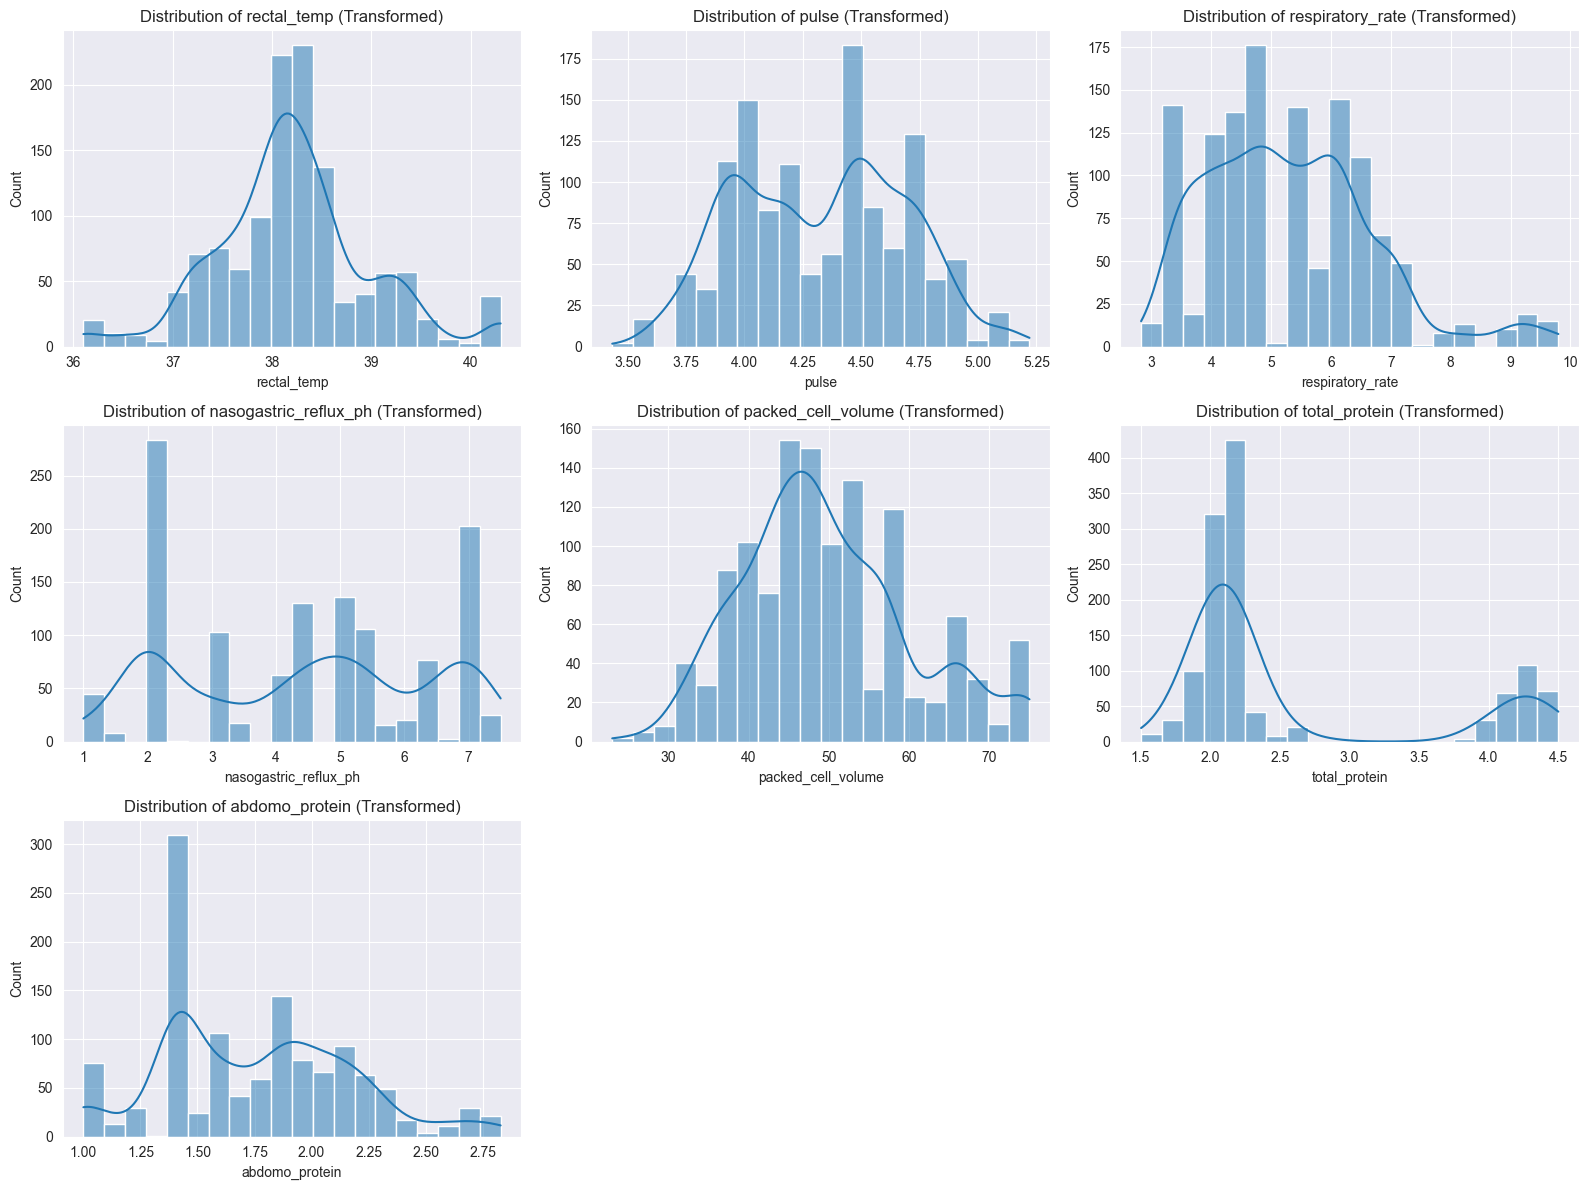

Feature  P-Value with Outliers  P-Value without Outliers
0            rectal_temp                   0.57                      0.01
1                  pulse                   0.00                      0.00
2       respiratory_rate                   0.00                      0.00
3  nasogastric_reflux_ph                   0.00                      0.00
4     packed_cell_volume                   0.00                      0.00
5          total_protein                   0.00                      0.00
6         abdomo_protein                   0.00                      0.00

In [282]:
# Visualize the distributions of the transformed features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(transformed_data[feature], kde=True, bins=20)
    plt.title(f'Distribution of {feature} (Transformed)')
plt.tight_layout()
plt.show()

anova_df_transformed


* **Observation:**
    - The transformations have altered the skewness and distribution of the features.
    - The distributions appear to be more symmetric, indicating a reduction in skewness, especially for features like pulse and total_protein.

In [283]:
"""def Feature_enginerring(df):
    df['protein_ratio'] = df['total_protein'] / df['packed_cell_volume']

    # 2. Vital Signs Alert
    pulse_75th_percentile = df['pulse'].quantile(0.75)
    respiratory_rate_75th_percentile = df['respiratory_rate'].quantile(0.75)
    df['vital_signs_alert'] = ((df['pulse'] > pulse_75th_percentile) & 
                                    (df['respiratory_rate'] > respiratory_rate_75th_percentile)).astype(int)

    # 3. Temperature Alert
    df['temperature_alert'] = ((df['rectal_temp'] < 37.5) | 
                                  (df['rectal_temp'] > 38.5)).astype(int)
    
Feature_enginerring(transformed_data)
Feature_enginerring(transformed_test_data)"""

In [ ]:
def Feature_enginerring(df):
    df["dehydrated"] = df["packed_cell_volume"] / df["total_protein"]  
    df["pulse_high"] = df["pulse"] * df["respiratory_rate"]
    df["protein"] =  df["total_protein"] -  df["abdomo_protein"]
Feature_enginerring(transformed_data)
Feature_enginerring(transformed_test_data)

In [284]:
transformed_data.head()

id  hospital_number  rectal_temp  pulse  respiratory_rate  \
0   0              109        38.10   4.89              4.90   
1   1              153        37.50   4.49              3.46   
2   2              101        38.30   4.80              5.29   
3   3              226        37.10   4.29              5.48   
4   4              252        38.00   3.97              6.93   

   nasogastric_reflux_ph  packed_cell_volume  total_protein  abdomo_protein  \
0                   6.50               57.00           2.25            1.84   
1                   2.00               33.00           4.17            1.41   
2                   3.50               37.00           2.00            1.84   
3                   2.00               53.00           2.08            1.97   
4                   7.00               47.00           2.12            1.61   

   lesion_1  ...  lesion_code_intrinsic  lesion_code_intussuption  \
0      2209  ...                      0                         0   
1      2208  ...                      0                         0   
2      5124  ...                      0                         0   
3      2208  ...                      0                         0   
4         0  ...                      0                         0   

  lesion_code_lipoma/slenic incarceration  lesion_code_none  \
0                                       1                 0   
1                                       0                 0   
2                                       0                 0   
3                                       0                 0   
4                                       0                 1   

   lesion_code_obturation  lesion_code_thromboembolic  \
0                       0                           0   
1                       0                           0   
2                       0                           0   
3                       0                           0   
4                       0                           0   

   lesion_code_volvulus/torsion  protein_ratio  vital_signs_alert  \
0                             0           0.04                  0   
1                             0           0.13                  0   
2                             0           0.05                  0   
3                             0           0.04                  0   
4                             0           0.05                  0   

   temperature_alert  
0                  0  
1                  0  
2                  0  
3                  1  
4                  0  

[5 rows x 87 columns]

In [285]:
transformed_data.drop(["lesion_site","lesion_type","lesion_subtype","lesion_code","lesion_1","lesion_2","lesion_3","id"],axis=1,inplace=True)
transformed_test_data.drop(["lesion_site","lesion_type","lesion_subtype","lesion_code","lesion_1","lesion_2","lesion_3"],axis=1,inplace=True)
#transformed_data.drop(["lesion_1","lesion_2","lesion_3","id"],axis=1,inplace=True)
#transformed_test_data.drop(["lesion_1","lesion_2","lesion_3"],axis=1,inplace=True)

In [286]:
transformed_data["outcome"]=transformed_data["outcome"].map({"died": 0,
                                       "euthanized": 1,
                                       "lived": 2
                                       })

# Modeling

In [288]:
# Define X and y
X = transformed_data.drop(['outcome'],axis=1)
y = transformed_data['outcome']
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=31)


In [289]:
num_cols = transformed_data.select_dtypes(include=['int64','int32','float64']).columns.tolist()

In [290]:
num_cols.remove('outcome')

## Feature Importance

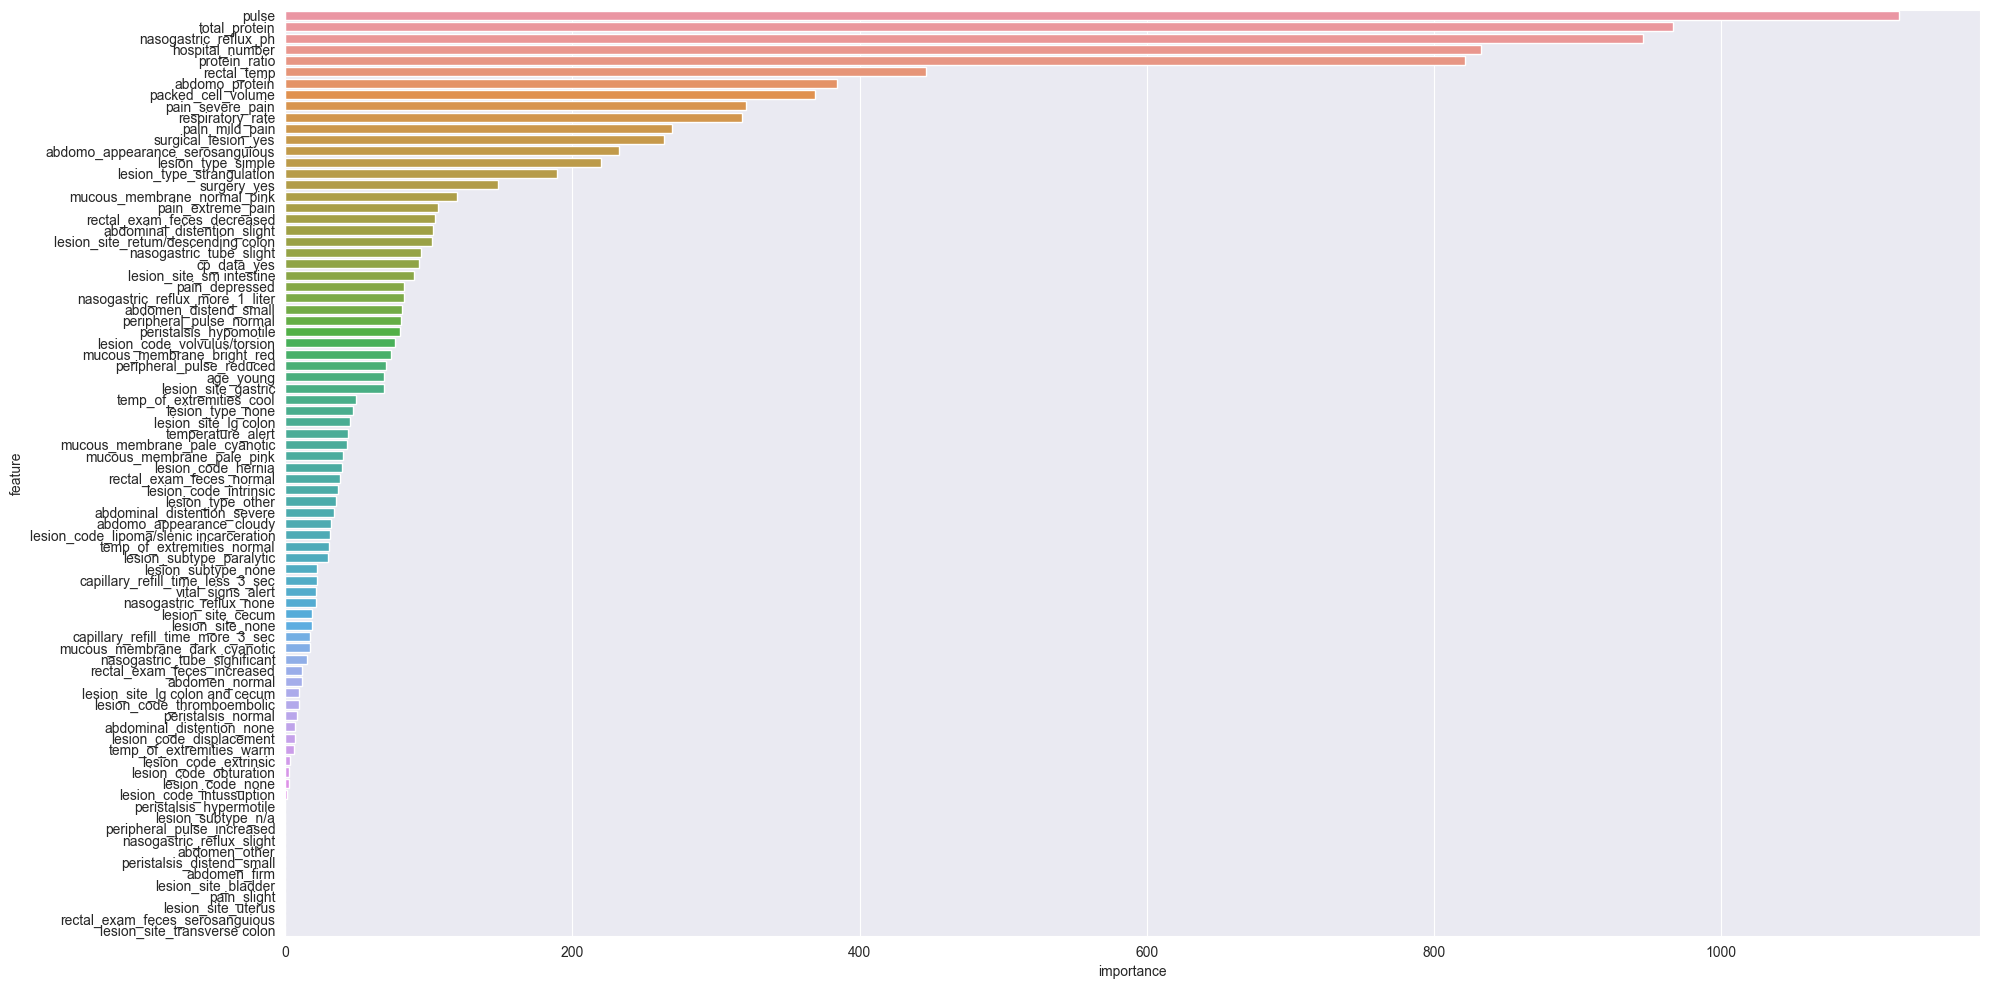

In [291]:

#Create Feature Selector Object
feat_selector = FeatureSelector(
    modeling_type='classification',
    X_train=X_train,
    y_train=y_train,
    X_test=X_val,
    y_test=y_val,
    numeric_columns=num_cols,  # Assuming num_cols is defined and holds the list of numerical columns
    categorical_columns=[],
    seed=31
)

# Get feature importances using LightGBM
lgbm_importance_df = feat_selector.lgbm_importance(
    hyperparam_dict=None,
    objective=None,
    return_plot=True
)

In [292]:
len(X_train.columns)

82

In [293]:
len(transformed_test_data.columns)

85

In [294]:
transformed_test_data.drop(['pain_moderate','outcome'],axis=1,inplace=True)

In [295]:
lgbm_importance_df.shape

(82, 2)

In [296]:
drop_list=lgbm_importance_df["feature"][-40:]
X_train.drop(drop_list, axis=1, inplace=True)
X_val.drop(drop_list, axis=1, inplace=True)
transformed_test_data.drop(drop_list, axis=1, inplace=True)

In [297]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit( X_train, X_val , y_train, y_val)
models

  0%|          | 0/29 [00:00<?, ?it/s]

 93%|█████████▎| 27/29 [00:03<00:00,  9.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 42
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Info] Start training from score -1.617568
[LightGBM] [Info] Start training from score -0.766632


100%|██████████| 29/29 [00:04<00:00,  6.69it/s]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.73               0.72    None      0.73   
BaggingClassifier                  0.68               0.68    None      0.68   
NearestCentroid                    0.68               0.68    None      0.69   
LinearDiscriminantAnalysis         0.70               0.67    None      0.70   
GaussianNB                         0.68               0.67    None      0.69   
BernoulliNB                        0.68               0.67    None      0.68   
LinearSVC                          0.70               0.67    None      0.70   
KNeighborsClassifier               0.69               0.67    None      0.69   
ExtraTreesClassifier               0.70               0.67    None      0.69   
AdaBoostClassifier                 0.68               0.66    None      0.68   
RidgeClassifier                    0.70               0.66    None      0.70   
CalibratedClassifierCV             0.70               0.66    None      0.69   
XGBClassifier                      0.68               0.66    None      0.68   
QuadraticDiscriminantAnalysis      0.67               0.66    None      0.67   
LogisticRegression                 0.69               0.66    None      0.68   
RidgeClassifierCV                  0.69               0.65    None      0.69   
LGBMClassifier                     0.68               0.65    None      0.68   
SVC                                0.69               0.65    None      0.68   
SGDClassifier                      0.67               0.65    None      0.67   
NuSVC                              0.68               0.64    None      0.68   
DecisionTreeClassifier             0.65               0.64    None      0.65   
LabelPropagation                   0.64               0.62    None      0.64   
LabelSpreading                     0.64               0.62    None      0.64   
PassiveAggressiveClassifier        0.64               0.62    None      0.64   
Perceptron                         0.63               0.60    None      0.63   
ExtraTreeClassifier                0.58               0.55    None      0.58   
DummyClassifier                    0.47               0.33    None      0.30   

                               Time Taken  
Model                                      
RandomForestClassifier               0.60  
BaggingClassifier                    0.23  
NearestCentroid                      0.02  
LinearDiscriminantAnalysis           0.03  
GaussianNB                           0.03  
BernoulliNB                          0.02  
LinearSVC                            0.45  
KNeighborsClassifier                 0.04  
ExtraTreesClassifier                 0.49  
AdaBoostClassifier                   0.25  
RidgeClassifier                      0.03  
CalibratedClassifierCV               0.19  
XGBClassifier                        0.55  
QuadraticDiscriminantAnalysis        0.05  
LogisticRegression                   0.06  
RidgeClassifierCV                    0.03  
LGBMClassifier                       0.48  
SVC                                  0.13  
SGDClassifier                        0.07  
NuSVC                                0.15  
DecisionTreeClassifier               0.05  
LabelPropagation                     0.14  
LabelSpreading                       0.13  
PassiveAggressiveClassifier          0.03  
Perceptron                           0.02  
ExtraTreeClassifier                  0.03  
DummyClassifier                      0.02

In [298]:

def objective_cat(trial):
    """Define the objective function"""

    params = {
        "iterations" : trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        "depth" : trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength" : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type" : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait" : trial.suggest_int("od_wait", 10, 50),
        "verbose" : False
        
    }


    model_cat = CatBoostClassifier(**params)
    model_cat.fit(X_train, y_train)
    y_pred = model_cat.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [299]:
study_cat = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cat.optimize(objective_cat, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [300]:
print('Best parameters', study_cat.best_params)

Best parameters {'iterations': 517, 'learning_rate': 0.06923975991530021, 'depth': 2, 'l2_leaf_reg': 0.0003521433768066463, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00042480268497779226, 'bagging_temperature': 7.825018482287138, 'od_type': 'IncToDec', 'od_wait': 22}


In [301]:
cat = CatBoostClassifier(**study_cat.best_params, verbose=False)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.7368421052631579


In [302]:

import optuna

def objective_lgb(trial):
    """Define the objective function"""

    params = {
        'objective': trial.suggest_categorical('objective', ['multiclass']),
        'metric': trial.suggest_categorical('metric', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }


    model_lgb = LGBMClassifier(**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [303]:
study_lgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 42
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Info] Start training from score -1.617568
[LightGBM] [Info] Start training from score -0.766632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [304]:
print('Best parameters', study_lgb.best_params)

Best parameters {'objective': 'multiclass', 'metric': 'multi_logloss', 'max_depth': 1, 'min_child_samples': 10, 'learning_rate': 0.27568845809093895, 'n_estimators': 193, 'min_child_weight': 5, 'subsample': 0.3437314331686504, 'colsample_bytree': 0.9771166915042535, 'reg_alpha': 0.8564871952971393, 'reg_lambda': 0.13651851648453256, 'random_state': 42}


In [305]:
lgb = LGBMClassifier(**study_lgb.best_params)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 42
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Info] Start training from score -1.617568
[LightGBM] [Info] Start training from score -0.766632


Accuracy:  0.7368421052631579


In [306]:
def objective_xg(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [307]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [308]:
print('Best parameters', study_xgb.best_params)

Best parameters {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.014020542942829539, 'n_estimators': 423, 'min_child_weight': 4, 'gamma': 6.769253420234046e-05, 'subsample': 0.4736341208564946, 'colsample_bytree': 0.04903509142411891, 'reg_alpha': 1.3128637144591542e-05, 'reg_lambda': 7.156336952091039e-05, 'eval_metric': 'mlogloss'}


In [309]:
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.7165991902834008


In [310]:
lgb_imp=(lgb.feature_importances_-lgb.feature_importances_.min())/(lgb.feature_importances_.max()-lgb.feature_importances_.min())
xgb_imp=(xgb.feature_importances_-xgb.feature_importances_.min())/(xgb.feature_importances_.max()-xgb.feature_importances_.min())
importances=pd.DataFrame({"Features": X_train.columns , "Importance_LGBM":lgb_imp*100, "Importance_XGB":xgb_imp*100})
importances

Features  Importance_LGBM  Importance_XGB
0                      hospital_number           100.00           19.59
1                          rectal_temp            14.13            2.98
2                                pulse            67.39           15.66
3                     respiratory_rate            26.09            5.96
4                nasogastric_reflux_ph            11.96           17.64
5                   packed_cell_volume            17.39           14.11
6                        total_protein            53.26           22.95
7                       abdomo_protein            20.65           15.82
8                          surgery_yes            19.57           18.10
9                            age_young             9.78           45.82
10            temp_of_extremities_cool             6.52           15.73
11             peripheral_pulse_normal             1.09           66.64
12            peripheral_pulse_reduced             6.52           41.48
13          mucous_membrane_bright_red             3.26            5.90
14         mucous_membrane_normal_pink             9.78           70.60
15       mucous_membrane_pale_cyanotic             7.61           14.89
16           mucous_membrane_pale_pink             0.00            0.01
17                      pain_depressed            19.57            9.95
18                   pain_extreme_pain            16.30           68.33
19                      pain_mild_pain             4.35          100.00
20                    pain_severe_pain            14.13           76.83
21              peristalsis_hypomotile             9.78           26.78
22         abdominal_distention_slight             8.70           17.55
23             nasogastric_tube_slight             2.17           10.86
24     nasogastric_reflux_more_1_liter             4.35           11.17
25         rectal_exam_feces_decreased             7.61           11.09
26            rectal_exam_feces_normal             5.43            7.15
27               abdomen_distend_small             0.00            1.00
28     abdomo_appearance_serosanguious             5.43           57.81
29                 surgical_lesion_yes             7.61           66.59
30                         cp_data_yes             9.78           26.93
31                 lesion_site_gastric            11.96           28.92
32                lesion_site_lg colon             3.26            2.01
33  lesion_site_retum/descending colon            14.13           32.43
34            lesion_site_sm intestine             0.00            0.00
35                    lesion_type_none            18.48           57.30
36                  lesion_type_simple            19.57           64.23
37           lesion_type_strangulation             4.35           42.19
38                  lesion_code_hernia             4.35            0.26
39        lesion_code_volvulus/torsion             5.43           26.77
40                       protein_ratio            57.61           20.22
41                   temperature_alert             0.00            2.70

In [311]:
voting = VotingClassifier(estimators=[('cat', cat),
                                      ('lgbm', lgb), 
                                      ('xgb', xgb)], voting='soft')
voting.fit(X_train,y_train)
voting_pred = voting.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, voting_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 42
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Info] Start training from score -1.617568
[LightGBM] [Info] Start training from score -0.766632
Accuracy:  0.7206477732793523


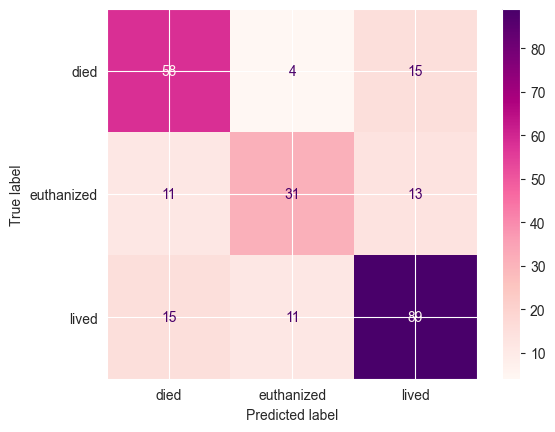

In [312]:
ConfusionMatrixDisplay.from_estimator(voting,X_val, y_val,display_labels=("died", "euthanized", "lived"),cmap="RdPu");

In [313]:
from sklearn.ensemble import StackingClassifier
stk = StackingClassifier(estimators=[('cat', cat),
                                      ('lgbm', lgb), 
                                      ('xgb', xgb)])
stk.fit(X_train,y_train)
stk_pred = stk.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, stk_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 42
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Info] Start training from score -1.617568
[LightGBM] [Info] Start training from score -0.766632
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 790, number of used features: 42
[LightGBM] [Info] Start training from score -1.088537
[LightGBM] [Info] Start training from score -1.61578

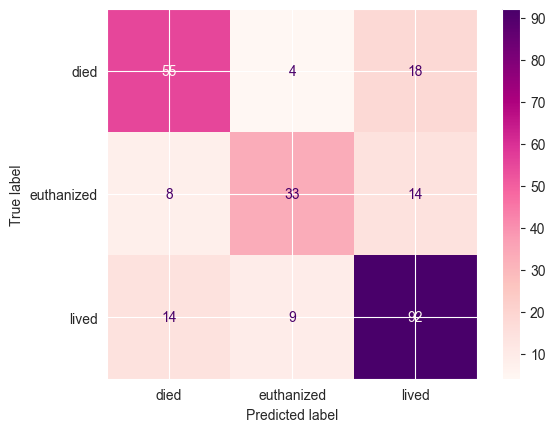

In [314]:
ConfusionMatrixDisplay.from_estimator(stk,X_val, y_val,display_labels=("died", "euthanized", "lived"),cmap="RdPu")

In [315]:
sub = pd.read_csv("sample_submission.csv")

In [316]:
sub["outcome"]=stk.predict(transformed_test_data.drop(columns=["id"] ))
sub["outcome"]=sub["outcome"].map({ 0: "died",
                                    1: "euthanized",
                                    2: "lived"
                                       })
sub.to_csv('submission.csv',index=False)
sub

id     outcome
0    1235       lived
1    1236        died
2    1237       lived
3    1238  euthanized
4    1239       lived
..    ...         ...
819  2054        died
820  2055  euthanized
821  2056        died
822  2057       lived
823  2058       lived

[824 rows x 2 columns]